In [22]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
import numpy as np

from keras.utils import image_dataset_from_directory
from tensorflow import keras 
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from tensorflow.data import Options


import psutil
import subprocess
import platform

In [23]:
# Verificar dispositivos físicos do tipo 'GPU' disponíveis
gpus = tf.config.list_physical_devices('GPU')

# Se houver GPUs disponíveis, configurar o memory growth
if gpus:
    try:
        for gpu in gpus:
            # Ativar crescimento dinâmico da memória da GPU
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        # Caso a GPU já tenha sido inicializada, não é possível alterar a configuração
        print(e)

GPU memory growth enabled.


In [24]:
# Caminho local para a pasta raiz do projeto
root_path = "./"  

# Listar diretorias no caminho raiz
print("Diretorias no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-noaug-70-15-15")
if os.path.exists(specific_path):
    print(f"\n Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n Caminho {specific_path} não existe")

# Função para listar diretorias com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretorias
print("\n Estrutura de diretorias:")
list_dirs(root_path, 0)

Diretorias no caminho raiz:
['.DS_Store', '.git', '.gitignore', 'app', 'assets', 'convert_to_js.py', 'convert_to_tf_lite.py', 'garbage-dataset', 'garbage-noaug-70-15-15', 'models', 'model_checkpoint.h5', 'Model_S_aug_compiled.ipynb', 'Model_S_aug_not_compiled.ipynb', 'Model_S_noaug_compiled.ipynb', 'Model_S_noaug_compiled_v2.ipynb', 'Model_S_noaug_not_compiled.ipynb', 'Model_S_noaug_not_compiled_v2.ipynb', 'Model_T_VGG16_aug_compiled.ipynb', 'Model_T_VGG16_aug_not_compiled.ipynb', 'Model_T_VGG16_noaug_compiled.ipynb', 'Model_T_VGG16_noaug_not_compiled.ipynb', 'README.md', 'requirements.txt', 'SSC.ipynb', 'ssc.py', 'web']

 Conteúdo de ./garbage-noaug-70-15-15:
['.DS_Store', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']

 Estrutura de diretorias:
📄 .DS_Store
📁 .git
  📄 COMMIT_EDITMSG
  📄 config
  📄 description
  📄 FETCH_HEAD
  📄 HEAD
  📁 hooks
    📄 applypatch-msg.sample
    📄 commit-msg.sample
    📄 fsmonitor-watchman.sample
    📄 post-update.sample
    📄 pre-a

In [25]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
GPU acceleration enabled (Metal)

Device being used: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
GPU test successful!


In [26]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [27]:
# Definição das diretorias de treino, validação e teste
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

# Definir o tamanho das imagens e o tamanho do batch
# (Imagens originais têm 640px, mas 128px acelera o treino)
IMG_SIZE = 128
BATCH_SIZE = 64


# Carregar o dataset de treino a partir da diretoria
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE), # Redimensionar imagens
    batch_size=BATCH_SIZE            # Dividir em batches
)

# Carregar o dataset de validação
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Carregar o dataset de teste
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Aplicar prefetching para otimizar o carregamento dos dados durante o treino
train_dataset_pref = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_pref = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_pref = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Limitar o número de batches de treino para testes mais rápidos
train_dataset_pref = train_dataset_pref.take(100)

# Ajustar opções do dataset para evitar paralelismo automático no batching
options = Options()
options.experimental_optimization.parallel_batch = False
train_dataset_pref = train_dataset_pref.with_options(options)


Found 13833 files belonging to 10 classes.
Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [28]:
# Check class balance
class_counts = {}
# Itera sobre os batches do dataset de treino
for _, labels in train_dataset:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Cria um DataFrame com a contagem por classe
df = pd.DataFrame({'class': train_dataset.class_names, 'count': [class_counts.get(i, 0) for i in range(len(train_dataset.class_names))]})

# Mostra o DataFrame
print(df)

        class  count
0     battery    666
1  biological    690
2   cardboard   1297
3     clothes   3730
4       glass   2093
5       metal    708
6       paper   1184
7     plastic   1382
8       shoes   1410
9       trash    673


In [29]:
# Definir a arquitetura da CNN com BatchNormalization antes da ativação
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

# Primeira camada convolucional
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

# Segunda camada convolucional
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

# Terceira camada convolucional
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

# Camadas densas
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Camada de saída
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax')(x)

# Criar o modelo
model = keras.Model(inputs=inputs, outputs=outputs)

# Otimizador
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

# Compilar o modelo
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,602 (32.37 MB)

 Trainable params: 8,485,642 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [30]:
# timeout callback to stop training after a certain time limit
class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_time_mins=2):
        super().__init__()
        self.max_time_sec = max_time_mins * 60
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed > self.max_time_sec:
            print(f"\nReached time limit ({self.max_time_sec/3600:.1f}h). Stopping training.")
            self.model.stop_training = True

# Maximum 20 minutes of training to prevent overheating
timeout_cb = TimeoutCallback(max_time_mins=20)


In [31]:
# Callback para early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

# Callback para salvar o modelo com melhor desempenho
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/model_checkpoint.keras", 
    save_best_only=True,
    monitor="val_accuracy"
)

# Add more callbacks for better training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Calculate class weights
total = sum(class_counts.values())
class_weight = {i: total/count for i, count in class_counts.items()}


In [32]:
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, check_interval=1):
        super().__init__()
        self.check_interval = check_interval
        self.epoch_count = 0
        self.is_mac = platform.system() == 'Darwin'
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % self.check_interval == 0:
            # Get basic info
            cpu_percent = psutil.cpu_percent(interval=0.5)
            memory = psutil.virtual_memory()
            mem_used = f"{memory.percent}% ({memory.used / 1024**3:.1f}GB)"
            
            # Temperature check - simplified
            temp = "N/A"
            if self.is_mac:
                try:
                    # Try thermal level from pmset (no sudo needed)
                    result = subprocess.run(['pmset', '-g', 'therm'], capture_output=True, text=True)
                    if "CPU_Thermal_level" in result.stdout:
                        temp = result.stdout.strip()
                except: pass
            
            # Simplified output
            print(f"\n[Epoch {epoch}] CPU: {cpu_percent}% | Memory: {mem_used}")
            print(f"Thermal: {temp}")
            print(f"GPU: {'Active' if self.is_mac else 'Unknown'}")

# Create monitor that checks every epoch
resource_monitor = ResourceMonitorCallback(check_interval=1)

In [34]:
# Número de classes (pode ser len(class_names))
NUM_CLASSES = len(train_dataset.class_names)

# Função para converter os rótulos para one-hot
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=NUM_CLASSES)

# Aplicar ao dataset
train_dataset_oh = train_dataset_pref.map(one_hot_encode)
validation_dataset_oh = validation_dataset_pref.map(one_hot_encode)


In [ ]:
# train the model with early stopping and resource monitoring
history = model.fit(
    train_dataset_oh,
    validation_data=validation_dataset_oh,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr, checkpoint_cb, timeout_cb, resource_monitor]
)


# Save the entire model (architecture + weights + optimizer state)
model.save("models/garbage_classifier_model_early_stopping_v2.keras")  
model.save_weights("models/garbage_classifier_early_stopping_v2.weights.h5")
print("Model saved successfully!")

Epoch 1/20


I0000 00:00:1749663710.480451    4282 service.cc:152] XLA service 0x7f139c005f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749663710.480512    4282 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-11 18:41:50.682451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749663712.016625    4282 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 18:42:14.809354: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng22{k2=3,k12=-1,k13=0,k14=0,k15=0,k17=32,k18=1,k23=0} for conv %cudnn-conv-bias-activation.11 = (f16[64,32,32,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,32,32,64]{3,2,1,0} %bitcast.8110, f16[128,3,3,64]{3,2,1,0} %bitcast.7814, f16[128]{0} %bitcast.7197), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_cal

 98/100 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.3057 - loss: 23.6731

2025-06-11 18:43:29.910963: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv %cudnn-conv-bias-activation.10 = (f16[21,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,64,64,32]{3,2,1,0} %bitcast.806, f16[64,3,3,32]{3,2,1,0} %bitcast.814, f16[64]{0} %bitcast.817), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_4_1/convolution" source_file="/home/diogo/venvs/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-06-11 18:43:29.915080: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 19.470547544s
Trying algo


[Epoch 0] CPU: 0.0% | Memory: 88.3% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 487ms/step - accuracy: 0.3091 - loss: 23.5262 - val_accuracy: 0.1369 - val_loss: 2.5417 - learning_rate: 0.0010
Epoch 2/20
 70/100 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 0.5842 - loss: 13.0659 
[Epoch 1] CPU: 0.9% | Memory: 88.1% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 396ms/step - accuracy: 0.5964 - loss: 12.6188 - val_accuracy: 0.2600 - val_loss: 2.4504 - learning_rate: 0.0010
Epoch 3/20
 31/100 ━━━━━━━━━━━━━━━━━━━━ 54s 793ms/step - accuracy: 0.7202 - loss: 9.2164
[Epoch 2] CPU: 0.0% | Memory: 88.4% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7314 - loss: 8.4983 - val_accuracy: 0.3673 - val_loss: 2.3539 - learning_rate: 0.0010
Epoch 4/20
 78/100 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.8161 - loss: 5.7075 
[Epoch 3] CPU: 0.0% | Memory: 88.2% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━

2025-06-11 18:49:10.452133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:60: Filling up shuffle buffer (this may take a while): 511 of 512
2025-06-11 18:49:10.452215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



[Epoch 17] CPU: 0.0% | Memory: 88.3% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9989 - loss: 0.1192 - val_accuracy: 0.7322 - val_loss: 1.0160 - learning_rate: 4.0000e-05
Epoch 19/20
  8/100 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - accuracy: 1.0000 - loss: 0.0928
[Epoch 18] CPU: 0.1% | Memory: 88.3% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9988 - loss: 0.1111 - val_accuracy: 0.7349 - val_loss: 1.0128 - learning_rate: 8.0000e-06
Epoch 20/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9991 - loss: 0.1076
[Epoch 19] CPU: 0.1% | Memory: 88.3% (5.7GB)
Thermal: N/A
GPU: Unknown
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9991 - loss: 0.1075 - val_accuracy: 0.7373 - val_loss: 1.0190 - learning_rate: 8.0000e-06
Model saved successfully!


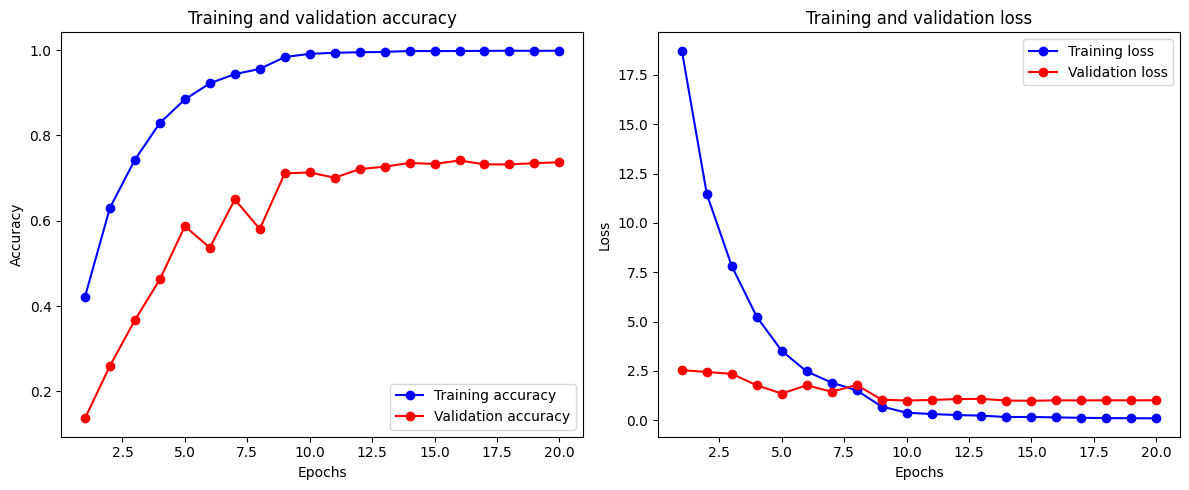

In [36]:
# Plot training history with data from the callbacks
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1) # Adjusted to match the number of epochs

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7609 - loss: 0.9391
Test accuracy: 0.7500
Test loss: 0.9895
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


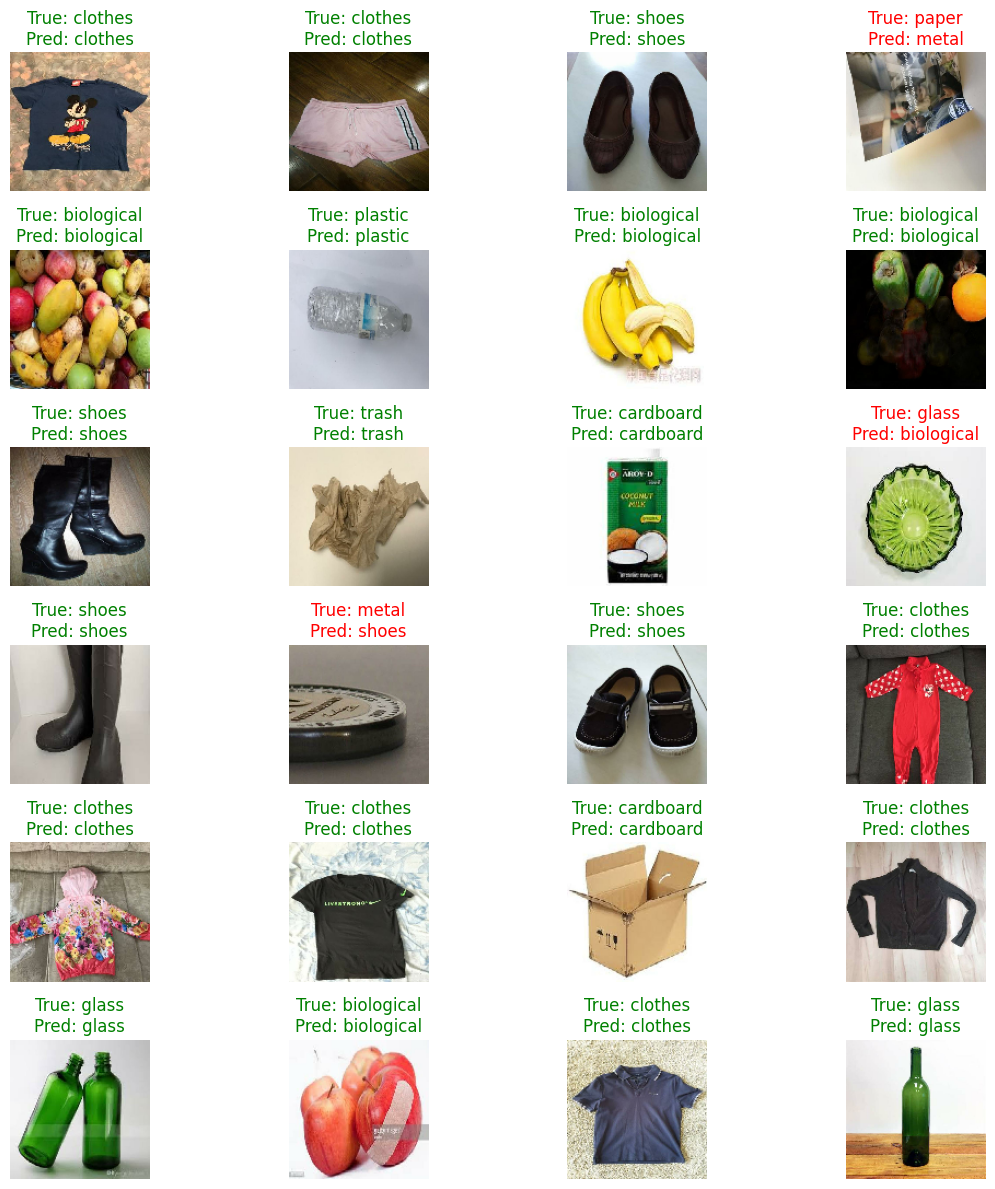

In [38]:
# One-hot encode test labels for evaluation
test_dataset_oh = test_dataset.map(one_hot_encode)

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset_oh)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get class names from your dataset
class_names = train_dataset.class_names
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(24):
        plt.subplot(6, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()